In [6]:
import json, re, sys, csv, math
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt

# FILE = 'model_data/hf_models_open_raw.json'

# --- Cell 1: Setup & helpers ---

import json, re, csv, math
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Path to your input JSON file (JSON array, single JSON object, or NDJSON)
INPUT_JSON = 'model_data/hf_models_open_raw.json'

# Regex to parse `card_data` string blocks like:
# "base_model: Qwen/WorldPM-72B\nlicense: apache-2.0"
BASE_REGEX = re.compile(r'(?im)^\s*base[_ ]model\s*:\s*(?P<val>.+?)\s*$', re.MULTILINE)
LIC_REGEX  = re.compile(r'(?im)^\s*license\s*:\s*(?P<val>.+?)\s*$', re.MULTILINE)

def load_records(fp: Path):
    """Load JSON or NDJSON into a list of dict records."""
    text = fp.read_text(encoding="utf-8", errors="ignore").strip()
    # Try JSON first
    try:
        obj = json.loads(text)
        if isinstance(obj, list):
            return obj
        elif isinstance(obj, dict):
            # Dict keyed by model name vs single record — normalize to list
            if obj and all(isinstance(v, dict) for v in obj.values()):
                recs = []
                for k, v in obj.items():
                    v = dict(v)
                    v.setdefault("model_name", v.get("modelId") or v.get("id") or k)
                    recs.append(v)
                return recs
            else:
                return [obj]
    except json.JSONDecodeError:
        pass

    # Try NDJSON
    records = []
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
            records.append(rec)
        except json.JSONDecodeError:
            continue
    if records:
        return records

    raise ValueError("Could not parse JSON or NDJSON. Please check the input file.")

def model_name_from_record(rec: dict):
    """Extract a model name from common fields."""
    for key in ("model_name", "modelId", "id", "name"):
        if key in rec and isinstance(rec[key], str) and rec[key].strip():
            return rec[key].strip()
    # Sometimes stored under a nested 'model' object
    if "model" in rec and isinstance(rec["model"], dict):
        for key in ("modelId", "id", "name"):
            if key in rec["model"] and isinstance(rec["model"][key], str):
                return rec["model"][key].strip()
    return None

def extract_from_card_data(card_data):
    """Pull base_model and license from 'card_data' (string or dict)."""
    base_model = None
    license_id = None
    if isinstance(card_data, str):
        m = BASE_REGEX.search(card_data)
        if m:
            base_model = m.group("val").strip().strip('"').strip("'")
        m2 = LIC_REGEX.search(card_data)
        if m2:
            license_id = m2.group("val").strip().strip('"').strip("'")
    elif isinstance(card_data, dict):
        base_model = (card_data.get("base_model") or card_data.get("base model"))
        license_id = card_data.get("license")
    return base_model, license_id

def build_genealogy(records):
    """Return nodes dict and edges list from records."""
    edges = []   # (child, parent)
    nodes = {}   # name -> dict(metadata)
    for rec in records:
        name = model_name_from_record(rec)
        card = rec.get("card_data") or rec.get("cardData") or rec.get("card") or rec.get("model_card")
        base_model, lic = extract_from_card_data(card)

        if name:
            nodes.setdefault(name, {"model_name": name, "license": None})
            if lic:
                nodes[name]["license"] = lic

        if name and base_model:
            parent = base_model.strip()
            edges.append((name, parent))
            nodes.setdefault(parent, {"model_name": parent, "license": None})
    return nodes, edges

def save_csvs(nodes, edges, base_path: Path):
    edges_csv = base_path.with_name(base_path.stem + "_genealogy_edges.csv")
    nodes_csv = base_path.with_name(base_path.stem + "_genealogy_nodes.csv")
    with edges_csv.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["child_model", "base_model"])
        w.writerows(edges)
    with nodes_csv.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["model_name", "license"])
        for n, meta in sorted(nodes.items()):
            w.writerow([meta["model_name"], meta.get("license") or ""])
    return nodes_csv, edges_csv

def draw_genealogy_png(nodes, edges, base_path: Path):
    """Draw a simple layered PNG (child → base_model)."""
    out_png = base_path.with_name(base_path.stem + "_genealogy.png")
    G = nx.DiGraph()
    G.add_nodes_from(nodes.keys())
    G.add_edges_from(edges)

    # Layered layout: group by distance to roots (in-degree 0)
    depths = {}
    for n in G.nodes:
        maxd = 0
        seen = set()
        frontier = [(n, 0)]
        while frontier:
            cur, d = frontier.pop()
            if cur in seen:
                continue
            seen.add(cur)
            preds = list(G.predecessors(cur))
            if not preds:
                maxd = max(maxd, d)
            else:
                for p in preds:
                    if d < 100:
                        frontier.append((p, d + 1))
        depths[n] = maxd

    layers = {}
    for n, dep in depths.items():
        layers.setdefault(dep, []).append(n)

    pos = {}
    for layer, ns in sorted(layers.items()):
        count = len(ns)
        for i, n in enumerate(sorted(ns)):
            x = i - (count - 1) / 2
            y = -layer
            pos[n] = (x, y)

    # plt.figure(figsize=(12, max(6, math.ceil(len(nodes) / 10))))
    plt.figure()
    nx.draw_networkx_nodes(G, pos, node_size=600)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=12, width=1)
    plt.axis("off")
    plt.title("Model Genealogy (child → base_model)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()
    return out_png


,model_name,license
0,- 01-ai/Yi-1.5-34B-32K,NaN
1,- A2va/openbuddy-llama3.1-8b-bnb-4bit,NaN
2,- AI-Sweden-Models/gpt-sw3-6.7b-v2,NaN
3,- AXCXEPT/AXCXEPT-phi-4-open-R1-Distill-EZOv1,NaN
4,- AXCXEPT/phi-4-open-R1-Distill-EZOv1,NaN
5,- ArliAI/Llama-3.1-8B-ArliAI-RPMax-v1.2,NaN
6,- BAAI/OpenSeek-Small-v1,NaN
7,- BAAI/bge-base-en-v1.5,NaN
8,- BAAI/bge-m3,NaN
9,- BAAI/bge-reranker-base,NaN


,child_model,base_model
0,johnjeanc/OpenRS-GRPO,deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
1,NaruseShiroha/opencapybara-math-smol-4.1B-inst...,NaruseShiroha/capybara-math-smol-4.1B
2,Zachary1150/OpenRS-GRPO,deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
3,zkzhang88/OpenCodeEdit-Qwen2.5-7B,- Qwen/Qwen2.5-Coder-7B
4,zkzhang88/OpenCodeEdit-DSC-6.7B,- deepseek-ai/deepseek-coder-6.7b-base
5,Harsh1729/R1-Distill-Llama-8B-SFT-cotroller_da...,deepseek-ai/DeepSeek-R1-Distill-Llama-8B
6,Harsh1729/R1-Distill-Llama-8B-SFT-cotroller_da...,deepseek-ai/DeepSeek-R1-Distill-Llama-8B
7,zkzhang88/OpenCodeEdit-Qwen3-8B,- Qwen/Qwen3-8B-Base
8,OpenVoiceOS/phoonnx_eu-ES_dii_espeak,- OpenVoiceOS/phoonnx_eu-ES_miro_espeak
9,Ziyao1010/Qwen2.5-1.5B-Open-R1-GRPO-Math,Qwen/Qwen2.5-1.5B-Instruct


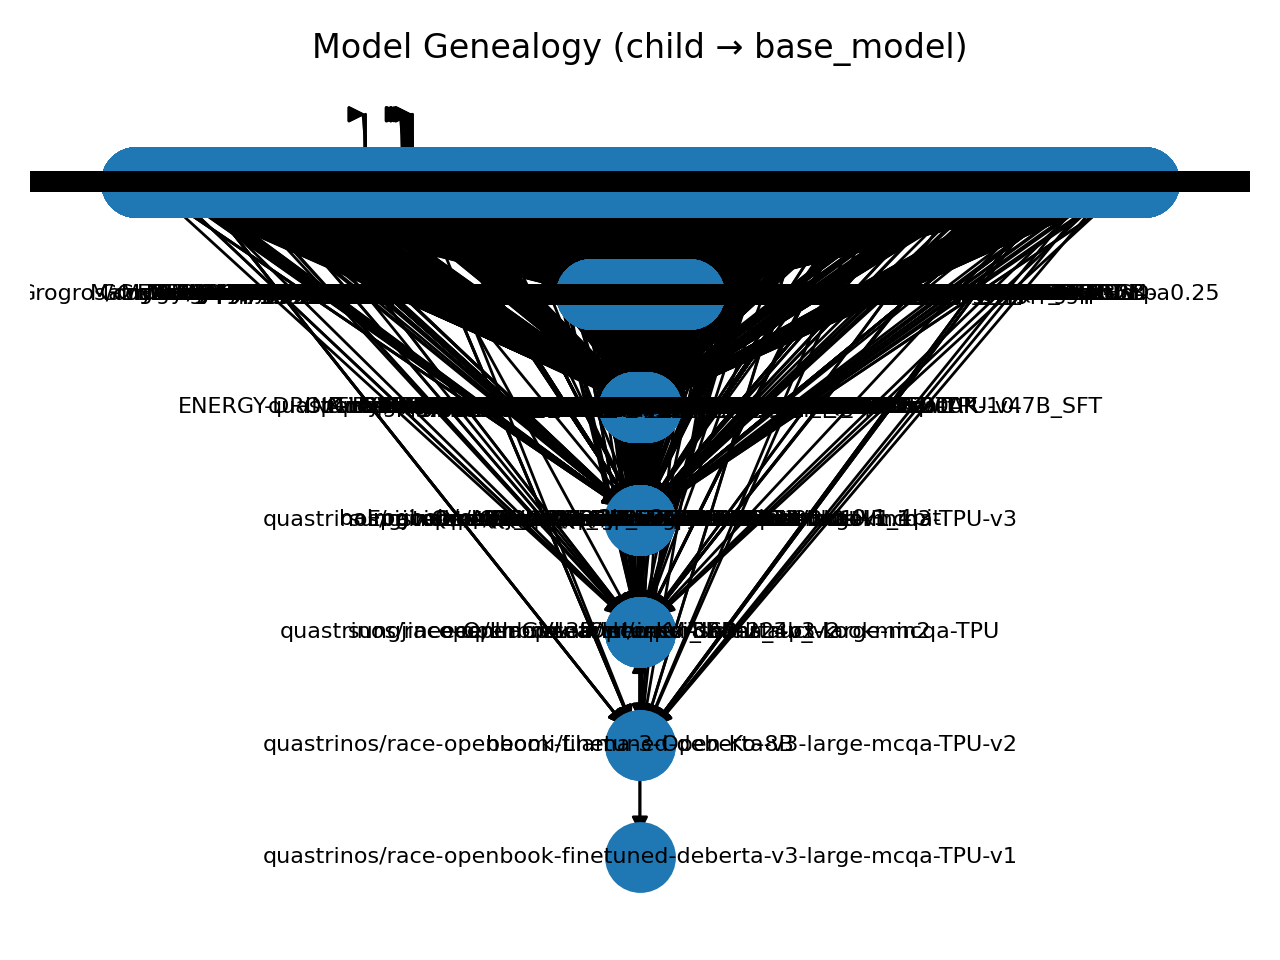

In [7]:
# --- Cell 2: Run the pipeline & display results ---

from pathlib import Path
from IPython.display import display, Image

in_path = Path(INPUT_JSON)
# if not in_path.exists():
#     # Minimal demo if your file isn't present yet
#     demo = [
#         {"model_name": "MyOrg/Tiny-Model-v1", "card_data": "base_model: Qwen/WorldPM-72B\nlicense: apache-2.0"},
#         {"modelId": "MyOrg/Tiny-Model-v2", "card_data": "base_model: MyOrg/Tiny-Model-v1\nlicense: mit"},
#         {"id": "OtherOrg/Unrelated", "card_data": "license: cc-by-4.0"},
#     ]
#     in_path = Path("/mnt/data/demo_models.json")
#     in_path.write_text(json.dumps(demo, indent=2), encoding="utf-8")

records = load_records(in_path)
nodes, edges = build_genealogy(records)

nodes_csv, edges_csv = save_csvs(nodes, edges, in_path)
png_path = draw_genealogy_png(nodes, edges, in_path)

# Show DataFrames inline
nodes_df = pd.read_csv(nodes_csv)
edges_df = pd.read_csv(edges_csv)
display(nodes_df.head(20))
display(edges_df.head(20))

# Show the PNG inline
display(Image(filename=str(png_path)))

# print("Saved files:")
# print(f"  Nodes CSV: {nodes_csv}")
# print(f"  Edges CSV: {edges_csv}")
# print(f"  PNG:       {png_path}")


## Getting All the Base Models
Many models are based on other models. Let's look at the ones' that aren't based on other models, that is lets look only at the base models

List	Includes synthetic parents?	Use case
allnodes	✅ yes — even if only mentioned as base_model	To reconstruct the full dependency tree and discover external roots (e.g., “Llama-3-70B”, “Qwen-1.5B”, etc.)
in_records_only	❌ no — only models actually in your JSON	To identify which models in your dataset are top-level (not derived from others)

In [10]:
# --- Cell: List base models and save to a custom path ---

from pathlib import Path
import pandas as pd

# Input JSON path
INPUT_JSON = "model_data/hf_models_open_raw.json"   # change as needed

# Output directory or prefix (you can point anywhere accessible in your environment)
SAVE_DIR = Path("model_genealogy/")  # directory for saving files
SAVE_DIR.mkdir(parents=True, exist_ok=True)  # create if missing

# Load records and build genealogy (uses helpers from setup cell)
records = load_records(Path(INPUT_JSON))
nodes, edges = build_genealogy(records)

# Any model that appears as a child has a parent
children = {c for c, p in edges}

# All models and their names
all_nodes = set(nodes.keys())
present_models = set(filter(None, (model_name_from_record(r) for r in records)))

# Base models (no parent)
base_models_allnodes = sorted(all_nodes - children)
base_models_in_records_only = sorted(present_models - children)

# Create DataFrames
df_all = pd.DataFrame({"base_model": base_models_allnodes})
df_present_only = pd.DataFrame({"base_model_in_records_only": base_models_in_records_only})

# Custom save paths
csv_all = SAVE_DIR / "base_models_allnodes.csv"
csv_present = SAVE_DIR / "base_models_in_records_only.csv"

# Save to CSVs
df_all.to_csv(csv_all, index=False)
df_present_only.to_csv(csv_present, index=False)

# Display preview and save info
from IPython.display import display
display(df_all.head(20))
display(df_present_only.head(20))

print(f"✅ Saved CSVs to:\n  {csv_all}\n  {csv_present}")


,base_model
0,- 01-ai/Yi-1.5-34B-32K
1,- A2va/openbuddy-llama3.1-8b-bnb-4bit
2,- AI-Sweden-Models/gpt-sw3-6.7b-v2
3,- AXCXEPT/AXCXEPT-phi-4-open-R1-Distill-EZOv1
4,- AXCXEPT/phi-4-open-R1-Distill-EZOv1
5,- ArliAI/Llama-3.1-8B-ArliAI-RPMax-v1.2
6,- BAAI/OpenSeek-Small-v1
7,- BAAI/bge-base-en-v1.5
8,- BAAI/bge-m3
9,- BAAI/bge-reranker-base


,base_model_in_records_only
0,0c3107/openjourney
1,0farecom/roberta-base-openai-detector
2,0ho/llama-chat-openssl-0220
3,0ho/llama-chat-openssl-0227
4,0ho/llama2_openssl_test
5,0ho/llama_openssl_0227
6,0xtimmy/Qwen2.5-1.5B-Open-R1-Distill
7,1038lab/ViT-L-14_openai
8,1231czx/llama3_sft_openrlhf_continue_dart_1epoch
9,1231czx/llama3_sft_openrlhf_continue_dart_2epoch


✅ Saved CSVs to:
  model_genealogy/base_models_allnodes.csv
  model_genealogy/base_models_in_records_only.csv


In [ ]:
# --- Cell: compute child counts per model and save CSV ---

from pathlib import Path
import pandas as pd
from collections import Counter

# Inputs (edit as needed)
INPUT_JSON = "model_data/hf_models_open_raw.json"                # your dataset
SAVE_DIR   = Path("model_genealogy")   # where to save the CSV
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Build genealogy
records = load_records(Path(INPUT_JSON))
nodes, edges = build_genealogy(records)

# Count children (out-degree) for each node
child_counts = Counter()
for child, parent in edges:
    child_counts[parent] += 1

# Set of models present as full records in your JSON
present_models = set(filter(None, (model_name_from_record(r) for r in records)))

# Whether a node has a parent in the dataset
children_set = {c for c, p in edges}  # models that appear as children
has_parent = {n: (n in children_set) for n in nodes.keys()}

# Build dataframe
rows = []
for n, meta in nodes.items():

    rows.append({
        "model_name": n,
        "num_children": child_counts.get(n, 0),
        "has_parent": has_parent[n],                         # True if it’s derived from another model
        "is_in_records": n in present_models,                # True if this model had a full record in your JSON
        "license": meta.get("license") or ""
    })

df = pd.DataFrame(rows).sort_values(["num_children", "model_name"], ascending=[False, True])

# Save
out_csv = SAVE_DIR / "model_child_counts.csv"
df.to_csv(out_csv, index=False)

# Show a preview
from IPython.display import display
display(df.head(30))

print(f"✅ Saved: {out_csv}")


{'model_name': 'OpenMOSE/RWKV-Seed-OSS-36B-hxa07A', 'license': 'apache-2.0'}
{'model_name': 'mradermacher/OpenCodeEdit-Qwen2.5-7B-GGUF', 'license': None}
{'model_name': 'johnjeanc/OpenRS-GRPO', 'license': None}
{'model_name': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'license': None}
{'model_name': 'NaruseShiroha/opencapybara-math-smol-4.1B-instruction-GGUF', 'license': 'apache-2.0'}
{'model_name': 'NaruseShiroha/capybara-math-smol-4.1B', 'license': None}
{'model_name': 'Zachary1150/OpenRS-GRPO', 'license': None}
{'model_name': 'od2961/Llama-8B-Open-R1-GRPO-math-v2', 'license': None}
{'model_name': 'hdong0/Qwen3-1.7B-Open-R1-GRPO_deepscaler_acc_16384', 'license': None}
{'model_name': 'zkzhang88/OpenCodeEdit-Qwen2.5-7B', 'license': 'apache-2.0'}
{'model_name': '- Qwen/Qwen2.5-Coder-7B', 'license': None}
{'model_name': 'zkzhang88/OpenCodeEdit-DSC-6.7B', 'license': 'apache-2.0'}
{'model_name': '- deepseek-ai/deepseek-coder-6.7b-base', 'license': None}
{'model_name': 'Harsh1729/R1-Disti

,model_name,num_children,has_parent,is_in_records,license,author
24,Qwen/Qwen2.5-1.5B-Instruct,342,False,False,,None
105,Qwen/Qwen2.5-7B-Instruct,253,False,False,,None
1086,teknium/OpenHermes-2.5-Mistral-7B,121,True,True,apache-2.0,None
3157,beomi/Llama-3-Open-Ko-8B-Instruct-preview,113,False,True,other,None
4236,Qwen/Qwen2.5-32B-Instruct,90,False,False,,None
3,deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B,88,False,False,,None
1840,mistralai/Mistral-7B-v0.1,87,False,False,,None
7379,meta-llama/Meta-Llama-3-8B,70,False,False,,None
1441,aaditya/Llama3-OpenBioLLM-8B,60,True,True,llama3,None
15259,microsoft/swin-tiny-patch4-window7-224,53,False,False,,None


✅ Saved: model_genealogy/model_child_counts.csv


## Grabing only base models (i.e. models with no parent)
- Looks at the models listed from our JSON file as well as synthetic models (referenced but not in data)

In [3]:
# --- Cell: Filter models that don't have a parent (root/base models) ---

import pandas as pd
from pathlib import Path

# Path to your child-count CSV (update if saved somewhere else)
CSV_PATH = Path("model_genealogy/model_child_counts.csv")

# Load CSV
df = pd.read_csv(CSV_PATH)

# Filter for models with no parent
# (i.e., has_parent == False or 0)
root_models = df[df["has_parent"] == False].copy()

# Sort for readability (optional)
root_models = root_models.sort_values("num_children", ascending=False)

# Show first few rows
from IPython.display import display
display(root_models.head(50))

# # Optional: save filtered results
out_csv = CSV_PATH.with_name("models_without_parents_v2.csv")
root_models.to_csv(out_csv, index=False)

print(f"✅ Found {len(root_models)} models without parents.")
print(f"Saved filtered list to: {out_csv}")

# --- Cell: Filter models that are not base models but that have more than 100 children ---

popular_models = df[df["num_children"] >= 50].copy()
popular_models = popular_models.sort_values("num_children", ascending=False)

out_csv = CSV_PATH.with_name("most_popular_models_v2.csv")
popular_models.to_csv(out_csv, index=False)


display(popular_models.head(5))



,model_name,num_children,has_parent,is_in_records,license,author
0,Qwen/Qwen2.5-1.5B-Instruct,342,False,False,NaN,NaN
1,Qwen/Qwen2.5-7B-Instruct,253,False,False,NaN,NaN
3,beomi/Llama-3-Open-Ko-8B-Instruct-preview,113,False,True,other,NaN
4,Qwen/Qwen2.5-32B-Instruct,90,False,False,NaN,NaN
5,deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B,88,False,False,NaN,NaN
6,mistralai/Mistral-7B-v0.1,87,False,False,NaN,NaN
7,meta-llama/Meta-Llama-3-8B,70,False,False,NaN,NaN
9,microsoft/swin-tiny-patch4-window7-224,53,False,False,NaN,NaN
11,ORIGINAL_REPO_NAME,48,False,False,NaN,NaN
12,black-forest-labs/FLUX.1-dev,41,False,False,NaN,NaN


✅ Found 14191 models without parents.
Saved filtered list to: model_genealogy/models_without_parents_v2.csv


,model_name,num_children,has_parent,is_in_records,license,author
0,Qwen/Qwen2.5-1.5B-Instruct,342,False,False,NaN,NaN
1,Qwen/Qwen2.5-7B-Instruct,253,False,False,NaN,NaN
2,teknium/OpenHermes-2.5-Mistral-7B,121,True,True,apache-2.0,NaN
3,beomi/Llama-3-Open-Ko-8B-Instruct-preview,113,False,True,other,NaN
4,Qwen/Qwen2.5-32B-Instruct,90,False,False,NaN,NaN
